<a href="https://colab.research.google.com/github/ZacharyMalonjao/FinMark-Machine-Learning/blob/main/MLPA_Datacleaning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import re





In [ ]:

customers=pd.read_csv('https://raw.githubusercontent.com/ZacharyMalonjao/FinMark-Machine-Learning/refs/heads/main/MLPA/customers_data.csv')
products=pd.read_csv('https://raw.githubusercontent.com/ZacharyMalonjao/FinMark-Machine-Learning/refs/heads/main/MLPA/products_data.csv')
transactions=pd.read_csv('https://raw.githubusercontent.com/ZacharyMalonjao/FinMark-Machine-Learning/refs/heads/main/MLPA/transactions_data.csv')


#Documentation for data cleaning methods
## Customer Table
1. Customer_ID ->      Linear Interpolation
2. Company_Name-> Dropped
3. Address -> Dropped
4. Company_Profit -> Median Interpolation, Ordinal Segmentation
## Product Table

1. Product_ID -> Linear Interpolation
2. Product_Name-> Dropped
3. Product_Price -> None, just formatting


## Transaction Table
1. Transaction_ID -> Linear Interpolation
2. Product_ID -> Dropped
3.  Company_ID -> Droppped
4. Quantity-> Median Intrerpolation
5. Transaction_Date -> NaT Flagging
Product_Price-> Dropped
6. Total_Cost-> Overrided(Quantity * Product_Price from Product_Table)

# Step 1: Customer Table

---



Repeat_Customer table is done based on whether the company has high or medium profit.

## 1a: Customers Table

In [ ]:
#Complete missing IDs
customers.isnull().sum()

,0
Company_ID,10
Company_Name,0
Company_Profit,12
Address,0


In [ ]:

customers = customers.reset_index(drop=True)
customers['Company_ID'] = [float(i) for i in range(1, len(customers)+1)]


In [ ]:
#Drop Cols
customers=customers.drop(columns=['Company_Name'])
customers=customers.drop(columns=['Address'])
customers.isnull().sum()

,0
Company_ID,0
Company_Profit,12


In [ ]:
#Clean company_profit (Median Imputation)


customers['Company_Profit'] = pd.to_numeric(
    customers['Company_Profit'], errors='coerce'
)

customers['Company_Profit'] = customers['Company_Profit'].fillna(customers['Company_Profit'].median())


In [ ]:
#Segment

customers['Company_Profit_Segment'] = pd.qcut(
    customers['Company_Profit'],
    q=3,
    labels=['Low', 'Medium', 'High']
)



In [ ]:
print(customers['Company_Profit_Segment'].value_counts())
print(customers['Company_Profit_Segment'].isna().sum())

Company_Profit_Segment
High      34
Low       33
Medium    33
Name: count, dtype: int64
0


In [ ]:
#Ordinal mapping
order={'Low':0,'Medium':1,'High':2}
customers['Company_Profit_Segment']=customers['Company_Profit_Segment'].map(order)

In [ ]:
#Final Table
customers.head()

,Company_ID,Company_Profit,Company_Profit_Segment
0,1.0,80701.0,1
1,2.0,80511.0,1
2,3.0,110664.0,2
3,4.0,75301.5,1
4,5.0,69427.0,1


## 1b. Transaction_ID


In [ ]:
#Fill in ID gaps
transactions = transactions.reset_index(drop=True)
transactions['Transaction_ID'] = [float(i) for i in range(1, len(transactions)+1)]

In [ ]:

transactions=transactions.drop(columns=['Unnamed: 0'])
transactions['Transaction_ID'].isna().sum()


np.int64(0)

In [ ]:
#Company_ID = delete missing values
print(transactions['Company_ID'].isna().sum())
transactions = transactions.dropna(subset=['Company_ID'])
print(transactions['Company_ID'].isna().sum())

1000
0


#Step 2:  Product Table Cleaning

In [ ]:

# Product_ID
products.loc[products['Product_ID'].isna(), 'Product_ID'] = [8, 16]
# Product_Price formatting
products['Product_Price']=(
    products['Product_Price']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .astype(float)
)

In [ ]:
#Double check missing values
products.isna().sum()

,0
Product_ID,0
Product_Name,0
Product_Price,0


In [ ]:
#Drop Label column
products=products.drop(columns=['Product_Name'])

       Product_ID  Product_Price
count    20.00000      20.000000
mean     10.50000  134680.000000
std       5.91608   39408.916971
min       1.00000   84000.000000
25%       5.75000  100800.000000
50%      10.50000  131600.000000
75%      15.25000  159600.000000
max      20.00000  224000.000000


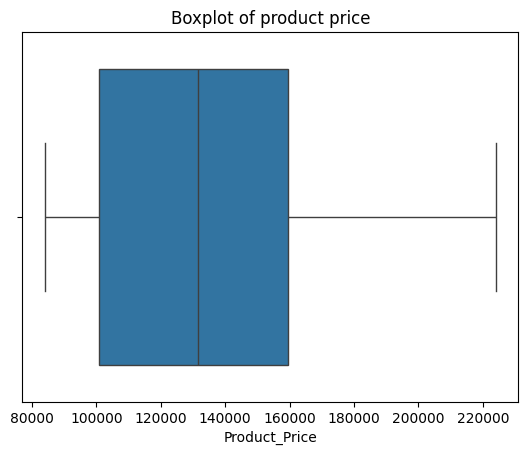

In [ ]:
#Check Outliers
print(products.describe())
sns.boxplot(x=products['Product_Price'])
plt.title('Boxplot of product price')
plt.show()

In [ ]:
products.head(20)

,Product_ID,Product_Price
0,1.0,140000.0
1,2.0,168000.0
2,3.0,100800.0
3,4.0,123200.0
4,5.0,84000.0
5,6.0,179200.0
6,7.0,151200.0
7,8.0,151200.0
8,9.0,112000.0
9,10.0,89600.0


#Step 3: Transaction table cleaning

## 3a. Drop columns

In [ ]:
# Drop Product Price because it is unreproduceable and no clear formula
transactions = transactions.drop(columns=['Product_Price'])



## 3b. Merge Products with Transactions

In transaction Table, Total_Cost = Quntity x Product_Price(From products table)

In [ ]:
transactions = transactions.merge(
    products[['Product_ID', 'Product_Price']],
    on='Product_ID',
    how='left'
)

## 3c. Clean Product_ID FK

In [ ]:
#Remove records with missing Product_ID
print(transactions['Product_ID'].isna().sum())
print(len(transactions))
#Missing values are only 10%, safe to delete

907
9000


In [ ]:
transactions = transactions.dropna(subset=['Product_ID']).copy()


## 3d. Clean quantity

In [ ]:
#Check Outliers
(transactions['Quantity'] < 0
).sum()

np.int64(0)

In [ ]:
#Median Imputation

transactions['Quantity'] = pd.to_numeric(
    transactions['Quantity'], errors='coerce'
)

transactions['Quantity'] = transactions['Quantity'].fillna(
    transactions['Quantity'].median()
)

## 3e. Recompute Total Cost based on cleaned Quantity

In [ ]:
transactions['Total_Cost'] = (
    transactions['Quantity'] * transactions['Product_Price']
)

In [ ]:
len(transactions)

8093

In [ ]:
print(transactions.columns.tolist())


['Transaction_ID', 'Company_ID', 'Product_ID', 'Quantity', 'Transaction_Date', 'Total_Cost', 'Product_Price']


In [ ]:
# Count missing values per column
print(transactions[['Transaction_ID', 'Company_ID', 'Product_ID', 'Quantity', 'Transaction_Date', 'Total_Cost', 'Product_Price']].isna().sum())

# Count rows with any missing value
print(transactions[['Transaction_ID', 'Company_ID', 'Product_ID', 'Quantity', 'Transaction_Date', 'Total_Cost', 'Product_Price']].isna().any(axis=1).sum())


Transaction_ID      0
Company_ID          0
Product_ID          0
Quantity            0
Transaction_Date    0
Total_Cost          0
Product_Price       0
dtype: int64
0


## 3f. Clean Date for forecasting

In [ ]:
transactions['Transaction_Date'] = pd.to_datetime(
    transactions['Transaction_Date'],
    errors='coerce',
    infer_datetime_format=True
)

transactions['Transaction_Date'].isna().sum()



/tmp/ipython-input-985262388.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  transactions['Transaction_Date'] = pd.to_datetime(


np.int64(6073)

## 3g. Merge Cutomers table

In [ ]:
transactions = transactions.merge(
    customers,
    how='left',
    on='Company_ID'
)


# Step 4: Feature Engineering

In [ ]:
transactions.isna().sum()

,0
Transaction_ID,0
Company_ID,0
Product_ID,0
Quantity,0
Transaction_Date,6073
Total_Cost,0
Product_Price,0
Company_Profit,0
Company_Profit_Segment,0


In [ ]:
transactions.head()

,Transaction_ID,Company_ID,Product_ID,Quantity,Transaction_Date,Total_Cost,Product_Price,Company_Profit,Company_Profit_Segment
0,1.0,88.0,6.0,11.0,2024-03-26,1971200.0,179200.0,75950.0,1
1,2.0,29.0,19.0,16.0,NaT,1523200.0,95200.0,61952.0,0
2,3.0,28.0,18.0,6.0,NaT,806400.0,134400.0,61115.0,0
3,4.0,85.0,12.0,12.0,NaT,1008000.0,84000.0,113470.0,2
4,5.0,47.0,3.0,8.0,NaT,806400.0,100800.0,31130.0,0


## 4a. Aggregate basic features
Needed columns:


1.   Purchase_Income (from Company_Profit_Segment)
2.   Total_Transactions → how many times the customer has bought before
3. Total_Quantity → total number of units purchased
4. Total_Spend → total amount of money spent
5. Avg_Order_Value → average amount spent per transaction
6. Days_Since_Last_Purchase → how recently the customer made a purchase




In [ ]:
#Aggregate column numbers 2, 3, 4 and 6 (See cell above )
customer_features  = transactions.groupby('Company_ID').agg(
    Total_Transactions=('Transaction_ID', 'count'),       # number of transactions
    Total_Quantity=('Quantity', 'sum'),                   # total units purchased
    Total_Spend=('Total_Cost', 'sum'),                    # total money spent
    Last_Purchase_Date=('Transaction_Date', 'max')        # last purchase (ignores NaT automatically)

).reset_index()

In [ ]:
#Create column number 5 (see 2 cells above)
customer_features['Avg_Order_Value'] = customer_features['Total_Spend'] / customer_features['Total_Transactions']
today = pd.Timestamp.today()



In [ ]:
#Create column number 6
customer_features['Days_Since_Last_Purchase'] = (today - customer_features['Last_Purchase_Date']).dt.days



In [ ]:
#Create column number1

# Merge the customer segment column
customer_features = customer_features.merge(
    customers[['Company_ID', 'Company_Profit_Segment']],
    on='Company_ID',
    how='left'
)

# Create Purchased target
customer_features['Purchased'] = customer_features['Company_Profit_Segment'].apply(lambda x: 1 if x >= 1 else 0)


In [ ]:
customer_features.head(20)

,Company_ID,Total_Transactions,Total_Quantity,Total_Spend,Last_Purchase_Date,Avg_Order_Value,Days_Since_Last_Purchase,Company_Profit_Segment,Purchased
0,1.0,61,656.0,86968000.0,2024-07-10,1.425705e+06,561,1,1
1,2.0,75,736.0,103712000.0,2024-10-05,1.382827e+06,474,1,1
2,3.0,78,797.0,103790400.0,2024-09-01,1.330646e+06,508,2,1
3,4.0,84,846.0,122623200.0,2024-07-26,1.459800e+06,545,1,1
4,5.0,80,797.0,106108800.0,2024-10-25,1.326360e+06,454,1,1
5,6.0,90,963.0,123844000.0,2024-04-29,1.376044e+06,633,0,0
6,7.0,77,819.0,112621600.0,2024-06-26,1.462618e+06,575,0,0
7,8.0,88,1006.0,130396000.0,2024-09-18,1.481773e+06,491,2,1
8,9.0,85,938.0,125899200.0,2024-09-21,1.481167e+06,488,2,1
9,10.0,88,849.0,112291200.0,2024-09-17,1.276036e+06,492,1,1
